In [1]:
from selenium import webdriver
import pandas as pd
from io import StringIO
from bs4 import BeautifulSoup
import re
import time
from datetime import date, datetime, timedelta
import pickle as pkl
import numpy as np
import matplotlib.pyplot as plt
from numpy import linalg as la
from scipy.linalg import cholesky
from scipy import stats
import random
import pulp
from pulp import *
import statsmodels.api as sm

## Pull in all of our data

In [2]:
file = open("../resources/latest_results.pkl",'rb')
historical_data = pkl.load(file)

In [3]:
historical_data['2020-09-13']['ACTUAL_POINTS'].head()

,Player,Pos,Avg,Fpts,NFL $5M Fantasy Football Millionaire [$1M to 1st],"NFL $300K Slant [$30K to 1st, 2x Min Cash]",NFL $500K Bootleg [$100K to 1st],NFL $2.5M Fantasy Football Millionaire [$1M to 1st],NFL $1M Luxury Box [$200K to 1st],NFL MASSIVE $25 Double Up
0,Boston Scott,RB/FLEX,51.01%,7.4,24.96% (-26.05),46.75% (-4.26),47.18% (-3.83),42.94% (-8.07),64.41% (13.40),79.82% (28.81)
1,Josh Jacobs,RB/FLEX,33.07%,35.9,25.44% (-7.63),27.52% (-5.55),29.36% (-3.71),28.02% (-5.05),35.00% (1.93),53.07% (20.00)
2,Davante Adams,WR/FLEX,32.57%,44.6,18.97% (-13.60),27.00% (-5.57),26.36% (-6.21),25.48% (-7.09),33.24% (0.67),64.39% (31.82)
3,Marvin Jones,WR/FLEX,25.78%,9.5,13.94% (-11.84),24.18% (-1.60),23.07% (-2.71),20.21% (-5.57),28.53% (2.75),44.78% (19.00)
4,Terry McLaurin,WR/FLEX,21.91%,11.1,15.69% (-6.22),20.17% (-1.74),18.95% (-2.96),19.00% (-2.91),22.94% (1.03),34.69% (12.78)


In [5]:
historical_data['2020-09-13']['PROJECTIONS']

{'Los Angeles Chargers': {'opp': '@ CIN',
  'position': 'DST',
  'points': 8.45,
  'powner': 0.10300000000000001,
  'salary': 2000.0,
  'team': 'LAC'},
 'Tyrod Taylor': {'opp': '@ CIN',
  'position': 'QB',
  'points': 19.81,
  'powner': 0.057999999999999996,
  'salary': 5300.0,
  'team': 'LAC'},
 'Detroit Lions': {'opp': 'CHI',
  'position': 'DST',
  'points': 7.07,
  'powner': 0.047,
  'salary': 2100.0,
  'team': 'DET'},
 'Jared Goff': {'opp': 'DAL',
  'position': 'QB',
  'points': 19.5,
  'powner': 0.0,
  'salary': 5800.0,
  'team': 'LAR'},
 'Patrick Mahomes': {'opp': 'HOU',
  'position': 'QB',
  'points': 25.66,
  'powner': 0.0,
  'salary': 7700.0,
  'team': 'KCC'},
 'Irv Smith': {'opp': 'GBP',
  'position': 'TE',
  'points': 9.67,
  'powner': 0.012,
  'salary': 2900.0,
  'team': 'MIN'},
 'Jimmy Garoppolo': {'opp': 'ARI',
  'position': 'QB',
  'points': 18.78,
  'powner': 0.049,
  'salary': 5700.0,
  'team': 'SFO'},
 'Deshaun Watson': {'opp': '@ KCC',
  'position': 'QB',
  'points':

In [6]:
PROJECTIONS = historical_data['2020-09-13']['PROJECTIONS']

In [96]:
historical_data['2020-09-13']['CONTESTS'][2]

{'Name': 'NFL $500K Play-Action [20 Entry Max]',
 'Link': 'Contest',
 'Prize Pool': '$500,000',
 'Buy In': '$3',
 'Top Prize': '$50,000',
 'Max Entries': 20,
 'Entries': 198177,
 'Cash Line': nan,
 'Winner': nan,
 'Winning Score': nan,
 'PAYOUTS':     Rank                  User  Points  Entries    Prize
 0      1           realsteel24  250.76        2  $50,000
 1      2   megatron1014 Member  246.68       20  $25,000
 2      3              Pizzat00  236.80       20  $15,000
 3      4  jamescarlsson Member  236.66       20  $10,000
 4      5         bulldawgs1979  234.48        5   $7,500
 ..   ...                   ...     ...      ...      ...
 45  8386         beaulabrecque  181.08       20       $6
 46  8386             JohnTKemp  181.08       20       $6
 47  8386        case987 Member  181.08       20       $6
 48  8386             tmlove325  181.08       11       $6
 49  8386               Codof77  181.08        8       $6
 
 [10050 rows x 5 columns]}

In [90]:
historical_data['2020-09-13']['CONTESTS'][1]['PAYOUTS'].tail(10)

,Rank,User,Points,Entries,Prize
40,9960,jaycole325,178.90,1,$10
41,9960,slc53,178.90,1,$10
42,9960,KlairVoyant Member,178.90,3,$10
43,9960,KlairVoyant Member,178.90,3,$10
44,9960,KlairVoyant Member,178.90,3,$10
45,9960,hishboo Member,178.90,150,$10
46,9960,ziploc19,178.90,3,$10
47,9960,Gambler5555 Member,178.90,37,$10
48,9960,Nitram99 Member,178.90,20,$10
49,10000,brianhaywood99,178.88,8,$10


In [9]:
PROJECTIONS

{'Los Angeles Chargers': {'opp': '@ CIN',
  'position': 'DST',
  'points': 8.45,
  'powner': 0.10300000000000001,
  'salary': 2000.0,
  'team': 'LAC'},
 'Tyrod Taylor': {'opp': '@ CIN',
  'position': 'QB',
  'points': 19.81,
  'powner': 0.057999999999999996,
  'salary': 5300.0,
  'team': 'LAC'},
 'Detroit Lions': {'opp': 'CHI',
  'position': 'DST',
  'points': 7.07,
  'powner': 0.047,
  'salary': 2100.0,
  'team': 'DET'},
 'Jared Goff': {'opp': 'DAL',
  'position': 'QB',
  'points': 19.5,
  'powner': 0.0,
  'salary': 5800.0,
  'team': 'LAR'},
 'Patrick Mahomes': {'opp': 'HOU',
  'position': 'QB',
  'points': 25.66,
  'powner': 0.0,
  'salary': 7700.0,
  'team': 'KCC'},
 'Irv Smith': {'opp': 'GBP',
  'position': 'TE',
  'points': 9.67,
  'powner': 0.012,
  'salary': 2900.0,
  'team': 'MIN'},
 'Jimmy Garoppolo': {'opp': 'ARI',
  'position': 'QB',
  'points': 18.78,
  'powner': 0.049,
  'salary': 5700.0,
  'team': 'SFO'},
 'Deshaun Watson': {'opp': '@ KCC',
  'position': 'QB',
  'points':

In [10]:
detailed_projections = pd.read_csv("../resources/projections_draftkings_nfl_2020-1.csv")

In [11]:
#we'll be using this data-set when plugging into linear optimization
detailed_projections.head(10)

,player_id,team,opp,pos,name,fpts,proj_own,ceil,floor,min_exposure,max_exposure
0,1849841,SEA,ATL,TE,Tyler Mabry,0.00,NaN,NaN,NaN,0,100
1,1844405,NEP,MIA,K,Justin Rohrwasser,0.00,NaN,NaN,NaN,0,100
2,1849791,LAR,DAL,RB,Xavier Jones,0.00,NaN,NaN,NaN,0,100
3,328578,NYJ,BUF,QB,Mike White,0.00,NaN,NaN,NaN,0,100
4,871255,IND,JAC,WR,Malik Henry,0.00,NaN,NaN,NaN,0,100
5,1844490,IND,JAC,TE,Farrod Green,0.00,NaN,NaN,NaN,0,100
6,982789,ARI,SFO,WR,Andy Isabella,3.25,0.1,6.47,0.29,0,100
7,875523,TEN,DEN,WR,Kristian Wilkerson,0.00,NaN,NaN,NaN,0,100
8,689689,CLE,BAL,TE,Pharaoh Brown,0.00,NaN,NaN,NaN,0,100
9,36967,NYG,PIT,RB,Wayne Gallman Jr.,0.53,NaN,1.06,0.01,0,100


### cleaning up some data

In [12]:
#TODO change teams
EXCLUDE = ['TEN', 'DEN', 'KCC','HOU', 'LAR', 'DAL', 'NYG', 'PIT']
detailed_projections = detailed_projections[~detailed_projections.team.isin(EXCLUDE)]
detailed_projections = detailed_projections.fillna(0)
detailed_projections

,player_id,team,opp,pos,name,fpts,proj_own,ceil,floor,min_exposure,max_exposure
0,1849841,SEA,ATL,TE,Tyler Mabry,0.00,0.0,0.00,0.0,0,100
1,1844405,NEP,MIA,K,Justin Rohrwasser,0.00,0.0,0.00,0.0,0,100
3,328578,NYJ,BUF,QB,Mike White,0.00,0.0,0.00,0.0,0,100
4,871255,IND,JAC,WR,Malik Henry,0.00,0.0,0.00,0.0,0,100
5,1844490,IND,JAC,TE,Farrod Green,0.00,0.0,0.00,0.0,0,100
...,...,...,...,...,...,...,...,...,...,...,...
943,11654,DET,CHI,QB,Chase Daniel,0.00,0.0,0.00,0.0,0,100
944,36834,CIN,LAC,TE,Mason Schreck,0.00,0.0,0.00,0.0,0,100
945,981968,BAL,CLE,WR,Miles Boykin,7.11,0.6,13.15,0.5,0,100
946,553024,SEA,ATL,TE,Tyler Ott,0.00,0.0,0.00,0.0,0,100


In [13]:
PROJECTIONS = {a:PROJECTIONS[a]for a in PROJECTIONS if PROJECTIONS[a]['team'] not in EXCLUDE}

In [14]:
len(set(historical_data['2020-09-13']['ACTUAL_POINTS'].Player))

670

In [15]:
len(set(detailed_projections.name))

717

In [16]:
len(set(detailed_projections.name).intersection(set(historical_data['2020-09-13']['ACTUAL_POINTS'].Player)))

650

In [17]:
juniors = set(historical_data['2020-09-13']['ACTUAL_POINTS'].Player)-set(detailed_projections.name)

In [18]:
#cleaning up some crap

In [19]:
players = historical_data['2020-09-13']['ACTUAL_POINTS'].Player
for i in range(len(players)):
    if players[i] in juniors:
        players[i] = players[i] + " Jr."
historical_data['2020-09-13']['ACTUAL_POINTS'].Player = players

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [20]:
historical_data['2020-09-13']['ACTUAL_POINTS'].Player

0           Boston Scott
1            Josh Jacobs
2          Davante Adams
3       Marvin Jones Jr.
4         Terry McLaurin
             ...        
665           Dan Godsil
666         Clark Harris
667    Donald Parham Jr.
668          Ryan Becker
669      Charlie Woerner
Name: Player, Length: 670, dtype: object

In [21]:
teams_translate = {
    "Arizona Cardinals": 'ARI',
    "Atlanta Falcons": "ATL",
    'Baltimore Ravens': "BAL",
    'Buffalo Bills': 'BUF',
    'Carolina Panthers': 'CAR',
    'Chicago Bears': 'CHI',
    'Cincinnati Bengals': 'CIN',
    'Cleveland Browns': 'CLE',
    'Dallas Cowboys': 'DAL',
    'Denver Broncos': 'DEN',
    'Detroit Lions': 'DET',
    'Green Bay Packers': 'GBP',
    'Houston Texans': 'HOU',
    'Indianapolis Colts': 'IND',
    'Jacksonville Jaguars': 'JAC',
    'Kansas City Chiefs': 'KCC',
    'Las Vegas Raiders': 'LVR',
    'Los Angeles Chargers': 'LAC',
    'Los Angeles Rams': 'LAR',
    'Miami Dolphins': 'MIA',
    'Minnesota Vikings': 'MIN',
    'New England Patriots': 'NEP',
    'New Orleans Saints': 'NOS',
    'New York Giants': 'NYG',
    'New York Jets': 'NYG',
    'Philadelphia Eagles': 'PHI',
    'Pittsburgh Steelers': 'PIT',
    'San Francisco 49ers': 'SFO',
    'Seattle Seahawks': 'SEA',
    'Tampa Bay Buccaneers': 'TBB',
    'Tennessee Titans' : 'TEN',
    'Washington Football Team': 'WAS'
}

In [22]:
teams_translate = {
    "Arizona Cardinals": 'Cardinals',
    "Atlanta Falcons": "Falcons",
    'Baltimore Ravens': "Ravens",
    'Buffalo Bills': 'Bills',
    'Carolina Panthers': 'Panthers',
    'Chicago Bears': 'Bears',
    'Cincinnati Bengals': 'Bengals',
    'Cleveland Browns': 'Browns',
    'Dallas Cowboys': 'Cowboys',
    'Denver Broncos': 'Broncos',
    'Detroit Lions': 'Lions',
    'Green Bay Packers': 'Packers',
    'Houston Texans': 'Texans',
    'Indianapolis Colts': 'Colts',
    'Jacksonville Jaguars': 'Jaguars',
    'Kansas City Chiefs': 'Chiefs',
    'Las Vegas Raiders': 'Raiders',
    'Los Angeles Chargers': 'Chargers',
    'Los Angeles Rams': 'Rams',
    'Miami Dolphins': 'Dolphins',
    'Minnesota Vikings': 'Vikings',
    'New England Patriots': 'Patriots',
    'New Orleans Saints': 'Saints',
    'New York Giants': 'Giants',
    'New York Jets': 'Jets',
    'Philadelphia Eagles': 'Eagles',
    'Pittsburgh Steelers': 'Steelers',
    'San Francisco 49ers': '49ers',
    'Seattle Seahawks': 'Seahawks',
    'Tampa Bay Buccaneers': 'Buccaneers',
    'Tennessee Titans' : 'Titans',
    'Washington Football Team': 'WAS Football Team'
}

In [23]:
left_over_crap = {
    'Allen Robinson': 'Allen Robinson II',
    'Bennie Fowler': 'Bennie Fowler III',
    'Benny Snell': 'Benny Snell Jr.',
    'D.J. Moore': 'DJ Moore',
    'D.K. Metcalf':'DK Metcalf',
    'Darrell Henderson': 'Darrell Henderson Jr.',
    'Gardner Minshew': 'Gardner Minshew II',
    'John Ross': 'John Ross III',
    'Khadarel Hodge': 'KhaDarel Hodge',
    'Mark Ingram': 'Mark Ingram II',
    'Ray-Ray McCloud': 'Ray-Ray McCloud III',
    'Ronald Jones': 'Ronald Jones II',
    'Todd Gurley': 'Todd Gurley II',
    'Van Jefferson': 'Van Jefferson Jr.',
    'Wayne Gallman': 'Wayne Gallman Jr.',
    'Willie Snead': 'Willie Snead IV'
}

In [24]:
players = list(PROJECTIONS.keys())
for i in range(len(players)):
    if players[i] in juniors:
        PROJECTIONS[players[i] + " Jr."] = PROJECTIONS[players[i]]
        del PROJECTIONS[players[i]]
    if players[i] in teams_translate:
        PROJECTIONS[teams_translate[players[i]]] = PROJECTIONS[players[i]]
        del PROJECTIONS[players[i]]
    if players[i] in left_over_crap:
        PROJECTIONS[left_over_crap[players[i]]] = PROJECTIONS[players[i]]
        del PROJECTIONS[players[i]]
    
#historical_data['2020-09-13']['ACTUAL_POINTS'].Player = players

In [25]:
len(teams_translate)

32

In [26]:
len(set(detailed_projections.name).intersection(set(historical_data['2020-09-13']['ACTUAL_POINTS'].Player)))

665

In [27]:
set(historical_data['2020-09-13']['ACTUAL_POINTS'].Player)-set(detailed_projections.name)
#this guy is irrelevant

{'C.J. Board Jr.',
 'Damion Ratley Jr.',
 'Daniel Helm Jr.',
 'Josh Dobbs Jr.',
 'Tavien Feaster Jr.'}

In [28]:
set(PROJECTIONS.keys())-set(detailed_projections.name)

set()

(array([400.,   4.,   0.,   0.,   3.,   5.,   2.,   0.,   0.,   1.]),
 array([ 0.   ,  1.399,  2.798,  4.197,  5.596,  6.995,  8.394,  9.793,
        11.192, 12.591, 13.99 ]),
 <a list of 10 Patch objects>)

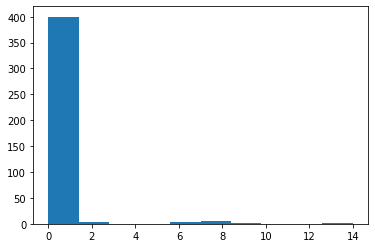

In [29]:
#those who aren't projected are a bunch of nobodies
x = detailed_projections[detailed_projections.name.isin(set(detailed_projections.name)-set(PROJECTIONS.keys()))]
plt.hist(x.fpts)

In [50]:
true_points = historical_data['2020-09-13']['ACTUAL_POINTS'][['Player', 'Fpts']].set_index('Player')['Fpts'].to_dict()

# Linear Optimization Time

In [30]:
def lineup(choices, players):
    return [player for player in players if (choices[player].varValue == 1)]

In [31]:
def add_position_constraint(prob,choices, projections, position, constraint):
    sub_players = [player for player in projections if projections[player]['position'] == position]
    prob += lpSum([choices[v] for v in sub_players]) >= constraint

In [32]:
def add_flex_constraint(prob,choices,  projections):
    sub_players = [player for player in projections if projections[player]['position'] in ['RB', 'WR', 'TE']]
    prob += lpSum([choices[v] for v in sub_players]) == 7

In [45]:
def add_qb_wr_constraint(prob, choices, projections, team):
    goofy_list = []
    for player in projections:
        if projections[player]['position'] == 'QB' and projections[player]['team'] == team:
            goofy_list.append(1)
        elif projections[player]['position'] == 'WR' and projections[player]['team'] == team:
            goofy_list.append(-1)
        else: 
            goofy_list.append(0)
    prob += pulp.lpDot([choices[v] for v in projections], goofy_list) <=  0

In [34]:
def actual_score_calc(true_points, players):
    total = 0
    for player in players:
        if player not in true_points:
            print("warning, player {} not in actual results".format(player))
        else:
            total += true_points[player]
    return total

In [35]:
def output_lineup(PROJECTIONS, detailed_projections):
    players = list(PROJECTIONS.keys())
    teams = set([PROJECTIONS[player]['team'] for player in PROJECTIONS])
    prob = pulp.LpProblem("NFL Maximizing EV", pulp.LpMaximize)
    choices = LpVariable.dicts("Choice", players, cat='Binary')
    # 9 people to a team
    prob += lpSum([choices[v] for v in players]) == 9
    #adding in the salary constraint
    prob += pulp.lpDot([choices[v] for v in players],[PROJECTIONS[name]['salary'] for name in players]) <= 50001


    #adding in position constraints
    add_position_constraint(prob, choices, PROJECTIONS, 'QB', 1)
    add_position_constraint(prob,choices, PROJECTIONS, 'RB', 2)
    add_position_constraint(prob,choices, PROJECTIONS, 'WR', 3)
    add_position_constraint(prob,choices, PROJECTIONS, 'TE', 1)
    add_position_constraint(prob,choices, PROJECTIONS, 'DST', 1)
    add_flex_constraint(prob,choices, PROJECTIONS)
    for team in teams:
        add_qb_wr_constraint(prob,choices, PROJECTIONS, team)

    #objective function
    #optimizing function
    prob += pulp.lpDot([choices[v] for v in players],
                           [PROJECTIONS[name]['points'] for name in players]), "Total Projection"
    prob.solve()
    print("expected ev is", value(prob.objective))
    print(lineup(choices, players))
    #print("total cost is", value(pulp.lpDot([choices[v] for v in players],[PROJECTIONS[name]['salary'] for name in players])))
    return lineup(choices, players)

In [36]:
def opt_var(PROJECTIONS, detailed_projections):
    players = list(PROJECTIONS.keys())
    ceils  = detailed_projections[['name', 'ceil']].set_index('name')['ceil'].to_dict()
    teams = set([PROJECTIONS[player]['team'] for player in PROJECTIONS])
    prob = pulp.LpProblem("NFL Maximizing EV", pulp.LpMaximize)
    choices = LpVariable.dicts("Choice", players, cat='Binary')
    # 9 people to a team
    prob += lpSum([choices[v] for v in players]) == 9
    #adding in the salary constraint
    prob += pulp.lpDot([choices[v] for v in players],[PROJECTIONS[name]['salary'] for name in players]) <= 50001


    #adding in position constraints
    add_position_constraint(prob, choices, PROJECTIONS, 'QB', 1)
    add_position_constraint(prob,choices, PROJECTIONS, 'RB', 2)
    add_position_constraint(prob,choices, PROJECTIONS, 'WR', 3)
    add_position_constraint(prob,choices, PROJECTIONS, 'TE', 1)
    add_position_constraint(prob,choices, PROJECTIONS, 'DST', 1)
    add_flex_constraint(prob,choices, PROJECTIONS)


    #optimizing function
    prob += pulp.lpDot([choices[v] for v in players],
                           [(ceils[name] - PROJECTIONS[name]['points']) if name in ceils else 0 for name in players ]), "Total Projection"
    prob.solve()
    return value(prob.objective)

In [76]:
def set_temp_variable(prob, choices, projections, team):
    teams = set([PROJECTIONS[player]['team'] for player in PROJECTIONS])
    y = ["offense_"+team for team in teams]
    goofy_list = []
    for player in projections:
        if projections[player]['position'] != 'DST' and projections[player]['team'] == team:
            goofy_list.append(-1)
        else: 
            goofy_list.append(0)
    teams_variables = [100 if x == team else 0 for x in teams]
    prob += pulp.lpDot([choices[v] for v in projections]+ \
                       [choices[v] for v in y], goofy_list+teams_variables) >=  0
    prob += pulp.lpDot([choices[v] for v in projections] + \
                       [choices[v] for v in y], goofy_list+teams_variables) <=  99

In [73]:
def set_defense_constraints(prob, choices, projections):
    teams = set([PROJECTIONS[player]['team'] for player in PROJECTIONS])
    for player in projections:
        if projections[player]['position'] == 'DST':
            opp = projections[player]['opp'].split()[-1]
            prob += choices[player] + choices["offense_"+opp] <= 1

In [63]:
PROJECTIONS

{'Tyrod Taylor': {'opp': '@ CIN',
  'position': 'QB',
  'points': 19.81,
  'powner': 0.057999999999999996,
  'salary': 5300.0,
  'team': 'LAC'},
 'Jimmy Garoppolo': {'opp': 'ARI',
  'position': 'QB',
  'points': 18.78,
  'powner': 0.049,
  'salary': 5700.0,
  'team': 'SFO'},
 'Russell Wilson': {'opp': '@ ATL',
  'position': 'QB',
  'points': 21.2,
  'powner': 0.083,
  'salary': 6500.0,
  'team': 'SEA'},
 'Matt Ryan': {'opp': 'SEA',
  'position': 'QB',
  'points': 21.27,
  'powner': 0.076,
  'salary': 6600.0,
  'team': 'ATL'},
 'Cam Newton': {'opp': 'MIA',
  'position': 'QB',
  'points': 20.46,
  'powner': 0.055,
  'salary': 6400.0,
  'team': 'NEP'},
 'Lamar Jackson': {'opp': 'CLE',
  'position': 'QB',
  'points': 26.22,
  'powner': 0.139,
  'salary': 8200.0,
  'team': 'BAL'},
 'Carson Wentz': {'opp': '@ WAS',
  'position': 'QB',
  'points': 19.17,
  'powner': 0.073,
  'salary': 6000.0,
  'team': 'PHI'},
 'Mitchell Trubisky': {'opp': '@ DET',
  'position': 'QB',
  'points': 17.27,
  'po

In [37]:
opt_var(PROJECTIONS, detailed_projections)

145.12

In [77]:
def output_lineups(PROJECTIONS, detailed_projections, n = 10, dist = 3):
    outputs = []
    
    ceils  = detailed_projections[['name', 'ceil']].set_index('name')['ceil'].to_dict()
    players = list(PROJECTIONS.keys())
    teams = set([PROJECTIONS[player]['team'] for player in PROJECTIONS])
    prob = pulp.LpProblem("NFL Maximizing EV", pulp.LpMaximize)
    
    temp_variables = ["offense_"+team for team in teams]
    print(temp_variables)
    choices = LpVariable.dicts("Choice", players+ temp_variables, cat='Binary')
    # 9 people to a team
    prob += lpSum([choices[v] for v in players]) == 9
    #adding in the salary constraint
    prob += pulp.lpDot([choices[v] for v in players],[PROJECTIONS[name]['salary'] for name in players]) <= 50001


    #adding in position constraints
    add_position_constraint(prob, choices, PROJECTIONS, 'QB', 1)
    add_position_constraint(prob,choices, PROJECTIONS, 'RB', 2)
    add_position_constraint(prob,choices, PROJECTIONS, 'WR', 3)
    add_position_constraint(prob,choices, PROJECTIONS, 'TE', 1)
    add_position_constraint(prob,choices, PROJECTIONS, 'DST', 1)
    add_flex_constraint(prob,choices, PROJECTIONS)
    
    #qb with at least one wide reciever
    for team in teams:
        add_qb_wr_constraint(prob,choices, PROJECTIONS, team)

    #add in variance optimization
    prob += pulp.lpDot([choices[v] for v in players],
                           [(ceils[name] - PROJECTIONS[name]['points']) if name in ceils else 0 for name in players ])\
                    >= .85*opt_var(PROJECTIONS, detailed_projections)
    
    #adding in no defense vs offense constraint
    for team in teams:
        set_temp_variable(prob, choices, PROJECTIONS, team)
    set_defense_constraints(prob, choices, PROJECTIONS)
    
    #optimizing function
    prob += pulp.lpDot([choices[v] for v in players],
                           [PROJECTIONS[name]['points'] for name in players]), "Total Projection"
    prob.solve()
    outputs.append(lineup(choices, players))
    
    for i in range(n-1):
        prob += lpSum([choices[v] for v in players if choices[v].varValue == 1]) <= dist
        prob.solve()
        outputs.append(lineup(choices, players))
        print("expected ev is", value(prob.objective))
    #print("total cost is", value(pulp.lpDot([choices[v] for v in players],[PROJECTIONS[name]['salary'] for name in players])))
    return outputs

In [78]:
potiential_lineups = output_lineups(PROJECTIONS, detailed_projections, dist = 5, n= 25)

['offense_MIA', 'offense_LVR', 'offense_NOS', 'offense_JAC', 'offense_DET', 'offense_SFO', 'offense_NYJ', 'offense_SEA', 'offense_NEP', 'offense_ATL', 'offense_CLE', 'offense_CIN', 'offense_CAR', 'offense_WAS', 'offense_GBP', 'offense_TBB', 'offense_CHI', 'offense_IND', 'offense_LAC', 'offense_PHI', 'offense_BAL', 'offense_BUF', 'offense_MIN', 'offense_ARI']
expected ev is 124.38
expected ev is 123.75
expected ev is 123.16999999999999
expected ev is 123.1
expected ev is 122.94000000000001
expected ev is 122.84
expected ev is 122.75999999999999
expected ev is 122.57
expected ev is 122.36000000000001
expected ev is 122.24000000000001
expected ev is 122.17
expected ev is 122.1
expected ev is 121.94
expected ev is 121.83
expected ev is 121.72999999999999
expected ev is 121.69999999999999
expected ev is 121.6
expected ev is 121.6
expected ev is 121.53999999999999
expected ev is 121.53
expected ev is 121.41999999999999
expected ev is 121.38
expected ev is 121.32
expected ev is 121.2399999999

In [379]:
output_lineup(PROJECTIONS, None)

expected ev is 152.11999999999998
['Tyrod Taylor', 'Boston Scott', 'Michael Thomas', 'Davante Adams', 'George Kittle', 'Joe Mixon', 'Keenan Allen', 'Chargers', 'Irv Smith Jr.']


['Tyrod Taylor',
 'Boston Scott',
 'Michael Thomas',
 'Davante Adams',
 'George Kittle',
 'Joe Mixon',
 'Keenan Allen',
 'Chargers',
 'Irv Smith Jr.']

In [87]:
for team in potiential_lineups:
    print("Team")
    for player in team:
        print(player, PROJECTIONS[player]['team'], PROJECTIONS[player]['position'],PROJECTIONS[player]['opp'])
    print()

Team
Kyler Murray ARI QB @ SFO
Davante Adams GBP WR @ MIN
Joe Mixon CIN RB LAC
Christian Kirk ARI WR @ SFO
Alvin Kamara NOS RB TBB
DeAndre Hopkins ARI WR @ SFO
Logan Thomas WAS TE PHI
Dolphins MIA DST @ NEP
Laviska Shenault Jr. JAC WR IND

Team
Kyler Murray ARI QB @ SFO
Davante Adams GBP WR @ MIN
Christian Kirk ARI WR @ SFO
Alvin Kamara NOS RB TBB
Aaron Jones GBP RB @ MIN
Jonathan Taylor IND RB @ JAC
Parris Campbell IND WR @ JAC
Logan Thomas WAS TE PHI
Chargers LAC DST @ CIN

Team
Kyler Murray ARI QB @ SFO
Davante Adams GBP WR @ MIN
Chris Herndon NYJ TE @ BUF
Alvin Kamara NOS RB TBB
Jonathan Taylor IND RB @ JAC
DeAndre Hopkins ARI WR @ SFO
Logan Thomas WAS TE PHI
Raiders LVR DST @ CAR
Odell Beckham Jr. CLE WR @ BAL

Team
Kyler Murray ARI QB @ SFO
Davante Adams GBP WR @ MIN
Chris Carson SEA RB @ ATL
Jonathan Taylor IND RB @ JAC
Parris Campbell IND WR @ JAC
DeAndre Hopkins ARI WR @ SFO
Logan Thomas WAS TE PHI
Dolphins MIA DST @ NEP
Marvin Jones Jr. DET WR CHI

Team
Kyler Murray ARI QB @ 

In [79]:
print([actual_score_calc(true_points, line) for line in potiential_lineups])

[167.2, 167.8, 170.2, 184.7, 140.3, 148.60000000000002, 166.9, 153.88000000000002, 139.1, 168.5, 148.4, 148.18, 167.20000000000002, 162.2, 152.7, 153.1, 179.20000000000002, 159.51999999999998, 195.57999999999998, 165.1, 121.9, 166.5, 148.26, 153.1, 161.89999999999998]


In [49]:
true_points

{'Boston Scott': 7.4,
 'Josh Jacobs': 35.9,
 'Davante Adams': 44.6,
 'Marvin Jones': 9.5,
 'Terry McLaurin': 11.1,
 'Lamar Jackson': 27.5,
 'DeSean Jackson': 6.6,
 'Antonio Gibson': 6.4,
 'Alvin Kamara': 23.7,
 'Marquise Brown': 18.1,
 'Austin Ekeler': 9.7,
 'Christian McCaffrey': 28.4,
 'DK Metcalf': 19.5,
 'Chris Godwin': 13.9,
 'WAS Football Team': 15.0,
 'Jets': 7.0,
 'Allen Robinson II': 12.3,
 'Hayden Hurst': 6.8,
 'Dalvin Cook': 21.8,
 'Todd Gurley II': 13.7,
 'George Kittle': 9.3,
 'Patriots': 11.0,
 'T.J. Hockenson': 16.6,
 'Chris Herndon': 8.7,
 'Jack Doyle': 7.9,
 'T.Y. Hilton': 9.3,
 'Calvin Ridley': 36.9,
 'Michael Thomas': 4.7,
 'Julio Jones': 27.7,
 'Chargers': 11.0,
 'Cam Newton': 25.7,
 'Colts': 4.0,
 'Zach Ertz': 10.8,
 'Mark Andrews': 22.8,
 'Joe Mixon': 7.1,
 'Odell Beckham': 5.2,
 'DJ Moore': 9.4,
 'Adam Thielen': 34.0,
 'Mitchell Trubisky': 24.28,
 'Russell Wilson': 34.78,
 'Tyler Lockett': 17.2,
 'Dolphins': 4.0,
 'Raheem Mostert': 25.1,
 'Julian Edelman': 13.0,


In [307]:
act_score = sum([true_points[name] for name in lineup(choices, players)])

In [308]:
print([(name, true_points[name]) for name in lineup(choices, players)])

[('Tyrod Taylor', 9.02), ('Boston Scott', 7.4), ('Michael Thomas', 4.7), ('Davante Adams', 44.6), ('George Kittle', 9.3), ('Joe Mixon', 7.1), ('Keenan Allen', 7.7), ('Chargers', 11.0), ('Irv Smith Jr.', 2.1)]


In [309]:
act_score

102.91999999999999

In [284]:
true_points

{'Fpts': {'Boston Scott': 7.4,
  'Josh Jacobs': 35.9,
  'Davante Adams': 44.6,
  'Marvin Jones Jr.': 9.5,
  'Terry McLaurin': 11.1,
  'Lamar Jackson': 27.5,
  'DeSean Jackson': 6.6,
  'Antonio Gibson': 6.4,
  'Alvin Kamara': 23.7,
  'Marquise Brown': 18.1,
  'Austin Ekeler': 9.7,
  'Christian McCaffrey': 28.4,
  'DK Metcalf': 19.5,
  'Chris Godwin': 13.9,
  'WAS Football Team': 15.0,
  'Jets': 7.0,
  'Allen Robinson II': 12.3,
  'Hayden Hurst': 6.8,
  'Dalvin Cook': 21.8,
  'Todd Gurley II': 13.7,
  'George Kittle': 9.3,
  'Patriots': 11.0,
  'T.J. Hockenson': 16.6,
  'Chris Herndon': 8.7,
  'Jack Doyle': 7.9,
  'T.Y. Hilton': 9.3,
  'Calvin Ridley': 36.9,
  'Michael Thomas': 4.7,
  'Julio Jones': 27.7,
  'Chargers': 11.0,
  'Cam Newton': 25.7,
  'Colts': 4.0,
  'Zach Ertz': 10.8,
  'Mark Andrews': 22.8,
  'Joe Mixon': 7.1,
  'Odell Beckham Jr.': 5.2,
  'DJ Moore': 9.4,
  'Adam Thielen': 34.0,
  'Mitchell Trubisky': 24.28,
  'Russell Wilson': 34.78,
  'Tyler Lockett': 17.2,
  'Dolphins

In [221]:
players

['Tyrod Taylor',
 'Jared Goff',
 'Jimmy Garoppolo',
 'Russell Wilson',
 'Matt Ryan',
 'Dak Prescott',
 'Cam Newton',
 'Lamar Jackson',
 'Carson Wentz',
 'Mitchell Trubisky',
 'Derek Carr',
 'Boston Scott',
 'Philip Rivers',
 'Kyler Murray',
 'Michael Thomas',
 'Ben Roethlisberger',
 'Teddy Bridgewater',
 'Davante Adams',
 'Matthew Stafford',
 'Baker Mayfield',
 'Kirk Cousins',
 'Daniel Jones',
 'George Kittle',
 'Drew Brees',
 'Josh Allen',
 'Tom Brady',
 'Joe Burrow',
 'Julio Jones',
 'Ryan Fitzpatrick',
 'Austin Ekeler',
 'Joe Mixon',
 'T.Y. Hilton',
 'Diontae Johnson',
 'Keenan Allen',
 'Dalvin Cook',
 'Zach Ertz',
 'Tyler Lockett',
 'Christian Kirk',
 'Terry McLaurin',
 'Aaron Rodgers',
 'Sam Darnold',
 'Christian McCaffrey',
 'Amari Cooper',
 'Kenyan Drake',
 'Ezekiel Elliott',
 'Antonio Gibson',
 'Robert Woods',
 'Josh Jacobs',
 'Jordan Reed',
 'Chris Carson',
 'Tyler Higbee',
 'Adam Thielen',
 'James Conner',
 'Mark Andrews',
 'Chris Herndon',
 'Jack Doyle',
 'DeSean Jackson',
 

In [231]:
PROJECTIONS

{'Tyrod Taylor': {'opp': '@ CIN',
  'position': 'QB',
  'points': 19.81,
  'powner': 0.057999999999999996,
  'salary': 5300.0,
  'team': 'LAC'},
 'Jared Goff': {'opp': 'DAL',
  'position': 'QB',
  'points': 19.5,
  'powner': 0.0,
  'salary': 5800.0,
  'team': 'LAR'},
 'Jimmy Garoppolo': {'opp': 'ARI',
  'position': 'QB',
  'points': 18.78,
  'powner': 0.049,
  'salary': 5700.0,
  'team': 'SFO'},
 'Russell Wilson': {'opp': '@ ATL',
  'position': 'QB',
  'points': 21.2,
  'powner': 0.083,
  'salary': 6500.0,
  'team': 'SEA'},
 'Matt Ryan': {'opp': 'SEA',
  'position': 'QB',
  'points': 21.27,
  'powner': 0.076,
  'salary': 6600.0,
  'team': 'ATL'},
 'Dak Prescott': {'opp': '@ LAR',
  'position': 'QB',
  'points': 21.76,
  'powner': 0.0,
  'salary': 6800.0,
  'team': 'DAL'},
 'Cam Newton': {'opp': 'MIA',
  'position': 'QB',
  'points': 20.46,
  'powner': 0.055,
  'salary': 6400.0,
  'team': 'NEP'},
 'Lamar Jackson': {'opp': 'CLE',
  'position': 'QB',
  'points': 26.22,
  'powner': 0.139,


In [225]:
[(name, PROJECTIONS[name]['salary']) for name in players]

[('Tyrod Taylor', 5300.0),
 ('Jared Goff', 5800.0),
 ('Jimmy Garoppolo', 5700.0),
 ('Russell Wilson', 6500.0),
 ('Matt Ryan', 6600.0),
 ('Dak Prescott', 6800.0),
 ('Cam Newton', 6400.0),
 ('Lamar Jackson', 8200.0),
 ('Carson Wentz', 6000.0),
 ('Mitchell Trubisky', 5500.0),
 ('Derek Carr', 5700.0),
 ('Boston Scott', 5000.0),
 ('Philip Rivers', 5900.0),
 ('Kyler Murray', 6100.0),
 ('Michael Thomas', 8000.0),
 ('Ben Roethlisberger', 6300.0),
 ('Teddy Bridgewater', 5800.0),
 ('Davante Adams', 8100.0),
 ('Matthew Stafford', 6200.0),
 ('Baker Mayfield', 5600.0),
 ('Kirk Cousins', 5900.0),
 ('Daniel Jones', 5800.0),
 ('George Kittle', 6700.0),
 ('Drew Brees', 6800.0),
 ('Josh Allen', 6700.0),
 ('Tom Brady', 6500.0),
 ('Joe Burrow', 5900.0),
 ('Julio Jones', 7400.0),
 ('Ryan Fitzpatrick', 5200.0),
 ('Austin Ekeler', 6500.0),
 ('Joe Mixon', 6100.0),
 ('T.Y. Hilton', 5700.0),
 ('Diontae Johnson', 4500.0),
 ('Keenan Allen', 5700.0),
 ('Dalvin Cook', 7600.0),
 ('Zach Ertz', 5600.0),
 ('Tyler Locke

In [223]:
[choices[v] for v in players]

[Choice_Tyrod_Taylor,
 Choice_Jared_Goff,
 Choice_Jimmy_Garoppolo,
 Choice_Russell_Wilson,
 Choice_Matt_Ryan,
 Choice_Dak_Prescott,
 Choice_Cam_Newton,
 Choice_Lamar_Jackson,
 Choice_Carson_Wentz,
 Choice_Mitchell_Trubisky,
 Choice_Derek_Carr,
 Choice_Boston_Scott,
 Choice_Philip_Rivers,
 Choice_Kyler_Murray,
 Choice_Michael_Thomas,
 Choice_Ben_Roethlisberger,
 Choice_Teddy_Bridgewater,
 Choice_Davante_Adams,
 Choice_Matthew_Stafford,
 Choice_Baker_Mayfield,
 Choice_Kirk_Cousins,
 Choice_Daniel_Jones,
 Choice_George_Kittle,
 Choice_Drew_Brees,
 Choice_Josh_Allen,
 Choice_Tom_Brady,
 Choice_Joe_Burrow,
 Choice_Julio_Jones,
 Choice_Ryan_Fitzpatrick,
 Choice_Austin_Ekeler,
 Choice_Joe_Mixon,
 Choice_T.Y._Hilton,
 Choice_Diontae_Johnson,
 Choice_Keenan_Allen,
 Choice_Dalvin_Cook,
 Choice_Zach_Ertz,
 Choice_Tyler_Lockett,
 Choice_Christian_Kirk,
 Choice_Terry_McLaurin,
 Choice_Aaron_Rodgers,
 Choice_Sam_Darnold,
 Choice_Christian_McCaffrey,
 Choice_Amari_Cooper,
 Choice_Kenyan_Drake,
 Choic

In [303]:
prob.valid()

True

In [201]:
prob

NFL Maximizing EV:
MAXIMIZE
7.5*Choice_49ers + 12.78*Choice_A.J._Green + 2.77*Choice_AJ_Dillon + 15.8*Choice_Aaron_Jones + 18.13*Choice_Aaron_Rodgers + 2.31*Choice_Adam_Shaheen + 18.0*Choice_Adam_Thielen + 0.59*Choice_Adam_Trautman + 4.66*Choice_Adrian_Peterson + 0.43*Choice_Alec_Ingold + 0.04*Choice_Alex_Erickson + 6.79*Choice_Alexander_Mattison + 11.63*Choice_Allen_Lazard + 16.11*Choice_Allen_Robinson_II + 19.2*Choice_Alvin_Kamara + 16.37*Choice_Amari_Cooper + 3.61*Choice_Andy_Isabella + 11.22*Choice_Anthony_Miller + 2.3*Choice_Antonio_Gandy_Golden + 11.04*Choice_Antonio_Gibson + 6.25*Choice_Auden_Tate + 17.83*Choice_Austin_Ekeler + 9.15*Choice_Austin_Hooper + 16.27*Choice_Baker_Mayfield + 6.77*Choice_Bears + 18.72*Choice_Ben_Roethlisberger + 5.77*Choice_Bengals + 0.12*Choice_Bennie_Fowler_III + 6.25*Choice_Benny_Snell_Jr. + 8.64*Choice_Bills + 1.42*Choice_Blake_Bell + 8.81*Choice_Blake_Jarwin + 15.48*Choice_Boston_Scott + 0.09*Choice_Brandon_Zylstra + 1.75*Choice_Braxton_Berrios + 7

In [198]:
[choices[key].value() for key in choices]

[1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.057428571,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0

In [185]:
[PROJECTIONS[name]['salary'] for name in lineup(choices, players)]

[5300.0, 5800.0, 5700.0, 6500.0, 6600.0, 6800.0, 8200.0, 2000.0]

In [176]:
PROJECTIONS

{'Tyrod Taylor': {'opp': '@ CIN',
  'position': 'QB',
  'points': 19.81,
  'powner': 0.057999999999999996,
  'salary': 5300.0,
  'team': 'LAC'},
 'Jared Goff': {'opp': 'DAL',
  'position': 'QB',
  'points': 19.5,
  'powner': 0.0,
  'salary': 5800.0,
  'team': 'LAR'},
 'Jimmy Garoppolo': {'opp': 'ARI',
  'position': 'QB',
  'points': 18.78,
  'powner': 0.049,
  'salary': 5700.0,
  'team': 'SFO'},
 'Russell Wilson': {'opp': '@ ATL',
  'position': 'QB',
  'points': 21.2,
  'powner': 0.083,
  'salary': 6500.0,
  'team': 'SEA'},
 'Matt Ryan': {'opp': 'SEA',
  'position': 'QB',
  'points': 21.27,
  'powner': 0.076,
  'salary': 6600.0,
  'team': 'ATL'},
 'Dak Prescott': {'opp': '@ LAR',
  'position': 'QB',
  'points': 21.76,
  'powner': 0.0,
  'salary': 6800.0,
  'team': 'DAL'},
 'Cam Newton': {'opp': 'MIA',
  'position': 'QB',
  'points': 20.46,
  'powner': 0.055,
  'salary': 6400.0,
  'team': 'NEP'},
 'Lamar Jackson': {'opp': 'CLE',
  'position': 'QB',
  'points': 26.22,
  'powner': 0.139,


In [276]:
floors = detailed_projections[['name', 'floor']].set_index('name').to_dict()
ceils  = detailed_projections[['name', 'ceil']].set_index('name').to_dict()

In [278]:
ceils

{'ceil': {'Tyler Mabry': 0.0,
  'Justin Rohrwasser': 0.0,
  'Xavier Jones': 0.0,
  'Mike White': 0.0,
  'Malik Henry': 0.0,
  'Farrod Green': 0.0,
  'Andy Isabella': 6.47,
  'Pharaoh Brown': 0.0,
  'Wayne Gallman Jr.': 1.06,
  'Tyler Conklin': 1.13,
  'Lamar Jackson': 35.84,
  'Omar Bayless': 0.0,
  'Carson Wentz': 27.4,
  'Hunter Henry': 18.64,
  'Ryan Succop': 11.85,
  'Peyton Barber': 15.94,
  'Brandon Powell': 0.0,
  'Cody Thompson': 0.0,
  'Patrick Taylor': 0.0,
  'Mark Andrews': 25.58,
  'Jason Vander Laan': 0.0,
  'Manasseh Bailey': 0.0,
  'DeAndre Hopkins': 35.25,
  'Josh Jacobs': 24.43,
  'Adrian Peterson': 17.59,
  'Antoine Wesley': 0.0,
  'J.J. Taylor': 0.91,
  'Jared Goff': 26.8,
  'Allen Lazard': 19.58,
  'Chris Lacy': 0.0,
  'Jauan Jennings': 0.0,
  'Jeff Cotton': 0.0,
  'DJ Chark Jr.': 22.05,
  'Alex Erickson': 0.08,
  'Giovanni Ricci': 0.0,
  'Kirk Merritt': 0.0,
  'Ronald Jones II': 19.65,
  'Josh Bellamy': 0.0,
  'Johnathon Johnson': 0.0,
  'Bruce Miller': 0.0,
  'Jus

In [269]:
detailed_projections

,player_id,team,opp,pos,name,fpts,proj_own,ceil,floor,min_exposure,max_exposure
0,1849841,SEA,ATL,TE,Tyler Mabry,0.00,0.0,0.00,0.0,0,100
1,1844405,NEP,MIA,K,Justin Rohrwasser,0.00,0.0,0.00,0.0,0,100
2,1849791,LAR,DAL,RB,Xavier Jones,0.00,0.0,0.00,0.0,0,100
3,328578,NYJ,BUF,QB,Mike White,0.00,0.0,0.00,0.0,0,100
4,871255,IND,JAC,WR,Malik Henry,0.00,0.0,0.00,0.0,0,100
...,...,...,...,...,...,...,...,...,...,...,...
943,11654,DET,CHI,QB,Chase Daniel,0.00,0.0,0.00,0.0,0,100
944,36834,CIN,LAC,TE,Mason Schreck,0.00,0.0,0.00,0.0,0,100
945,981968,BAL,CLE,WR,Miles Boykin,7.11,0.6,13.15,0.5,0,100
946,553024,SEA,ATL,TE,Tyler Ott,0.00,0.0,0.00,0.0,0,100
